# In this notebook, the ARIMA and SARIMA models will be explored

The methodology followed for producing an ARIMA model is summarized in the following flowchart, taken from Hyndmann.

![Hyndmann Modeling Porcess](hyndman-modeling-process.png)

In [276]:
%matplotlib inline

import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy import stats

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX

import tensorflow as tf
keras = tf.keras
from sklearn.model_selection import train_test_split

# Always make it pretty.
plt.style.use('ggplot')

# We get some interger -> float typecast warning from sklean below, this keeps them out of our hair.
import warnings
warnings.filterwarnings('ignore')

import pickle
from datetime import datetime

In [ ]:
# get the data
df_CHN_CTC_leaf = pd.read_csv('../Data/df_CHN_CTC_leaf.csv')
# print(df_CHN_CTC_leaf.tail(40))
# grab 2020 data separately
df_CHN_CTC_leaf_2020 = df_CHN_CTC_leaf[pd.to_datetime(df_CHN_CTC_leaf['week_ending']) > pd.to_datetime('2020-01-01')]
df_CHN_CTC_leaf = df_CHN_CTC_leaf[pd.to_datetime(df_CHN_CTC_leaf['week_ending']) < pd.to_datetime('2020-01-01')]

price_series = df_CHN_CTC_leaf['ctc_leaf_avg_price']
time_series = pd.to_datetime(df_CHN_CTC_leaf['week_ending'])
price_series.index = time_series

In [ ]:
price_series.plot();

In [ ]:
def plot_series_and_difference(axs, price_series, time_series, title):
    diff = price_series.diff()
    axs[0].plot(time_series, price_series)
    axs[0].set_title("Raw Series: {}".format(title))
    axs[1].plot(time_series, diff)
    axs[1].set_title("Series of First Differences: {}".format(title))

In [ ]:
fig, axs = plt.subplots(2, figsize=(14, 4))
plot_series_and_difference(axs, price_series, time_series, 'CTC Leaf (Cochin)')
fig.tight_layout()

In [ ]:
# Check for stationarity
price_differences = price_series.diff()[1:]
ADF_p_value = sm.tsa.stattools.adfuller(price_differences)
print("ADF p-value for differenced price series: {0:2.2f}".format(ADF_p_value[1]))

So the differenced series is stationary, and we can attempt to model it as an ARMA process.

We need to determine the correct order for the AR and MA models, so let's look at the auto and partial auto correlation plots.

In [ ]:
fig, ax = plt.subplots(1, figsize=(14, 3))
_ = sm.graphics.tsa.plot_acf(price_differences, lags=25, ax=ax)

In [ ]:
fig, ax = plt.subplots(1, figsize=(14, 3))
_ = sm.graphics.tsa.plot_pacf(price_differences, lags=25, ax=ax)

We see the following evidence:
  - Oscillatory behavior in the autocorrelation plot. One significant data point at the beginning of the plot. So ?????
  - One significant partial autocorrelations at the beginning of the plot.
  
This suggests that the differenced series may be well modeled as an $AR(1)$ series.

Since we applied *one* difference to achieve stationarity, this suggests that we should model the *original* series as an $ARIMA(1, 1, !)$.

In [ ]:
# # try 2nd rder differencing
# # Check for stationarity
# price_second_differences = price_differences.diff()[1:]
# ADF_p_value = sm.tsa.stattools.adfuller(price_second_differences)
# print("ADF p-value for differenced price series: {0:2.2f}".format(ADF_p_value[1]))

In [ ]:
# fig, ax = plt.subplots(1, figsize=(14, 3))
# _ = sm.graphics.tsa.plot_acf(price_second_differences, lags=25, ax=ax)
# fig, ax = plt.subplots(1, figsize=(14, 3))
# _ = sm.graphics.tsa.plot_pacf(price_second_differences, lags=25, ax=ax)

## Fit the ARIMA model

In [ ]:
price_model = ARIMA(price_series, order=(1, 1, 1)).fit()

In [ ]:
def format_list_of_floats(L):
    return ["{0:2.2f}".format(f) for f in L]

In [ ]:
print("ARIMA(1, 1, 0) coefficients from Price model:\n  Intercept {0:2.2f}\n  AR {1}".format(
    price_model.params[0], 
        format_list_of_floats(list(price_model.params[1:]))
    ))

Let's simulate some data using these coefficients and see if it looks like our differenced data.

In [ ]:
def auto_regressive_process(size, coefs, init=None):
    """Generate an autoregressive process with Gaussian white noise.  The
    implementation is taken from here:
    
      http://numpy-discussion.10968.n7.nabble.com/simulate-AR-td8236.html
      
    Exaclty how lfilter works here takes some pen and paper effort.
    """
    coefs = np.asarray(coefs)
    if init == None:
        init = np.array([0]*len(coefs))
    else:
        init = np.asarray(init)
    init = np.append(init, np.random.normal(size=(size - len(init))))
    assert(len(init) == size)
    a = np.append(np.array([1]), -coefs)
    b = np.array([1])
    return pd.Series(signal.lfilter(b, a, init))

In [ ]:
fig, ax = plt.subplots(4, figsize=(14, 8))

ax[0].plot(time_series[1:], price_differences)
ax[0].set_title("First Differences of Price Data")

for i in range(1, 4):
    simulated_data = auto_regressive_process(len(price_differences), 
                                             list(price_model.params)[1:])
    simulated_data.index = time_series[1:]
    ax[i].plot(simulated_data.index, simulated_data)
    ax[i].set_title("Simulated Data from Price Model Fit")
    
plt.tight_layout()

We have done a bit better than the naive forecast of predicting the last observed value.

We can also use the fit model to project prices into the future.

In [ ]:
price_model.summary()

In [ ]:
price_series[-100:]

In [ ]:
fig, ax = plt.subplots(1, figsize=(16, 3))
ax.plot(price_series.index, price_series)

# predictions = price_model.predict(
#    price_series.index.max(), pd.to_datetime('2020-09-12'), 
#    dynamic=True)

price_model = ARIMA(price_series, order=(1, 1, 1)).fit()

predictions = price_model.predict('2018-02-03', '2019-12-28', dynamic=True)
print(predictions)
ax.plot(predictions.index, predictions)
ax.set_title("Forecasts for Price")

If our model is good, the residuals should have no patterns whatsoever, i.e. be *white noise*

In [ ]:
fig, ax = plt.subplots(1, figsize=(14, 3))
ax.plot(price_model.resid.index, price_model.resid)
ax.set_title("Residuals from Price Model")
plt.tight_layout()

One way to diagnose this is to check if any autocorrelation remains in the residuals.

In [ ]:
fig, ax = plt.subplots(1, figsize=(14, 3))
_ = sm.graphics.tsa.plot_acf(price_model.resid, lags=50, ax=ax)

### Model Selection: AIC

In [ ]:
parameters = [
    {'AR': 2, 'MA': 0},
    {'AR': 2, 'MA': 1},
    {'AR': 1, 'MA': 0},
    {'AR': 1, 'MA': 1},
    {'AR': 3, 'MA': 0},
    {'AR': 3, 'MA': 1}
]

models = {}
for params in parameters:
    models[(params['AR'], params['MA'])] = ARIMA(price_series, order=(params['AR'], 1, params['MA'])).fit()
    
for model_params in models:
    print("ARIMA({}, 1, {}) AIC: {}".format(model_params[0], model_params[1], models[model_params].aic))

In [ ]:
# Calculating MAPE (Mean Absolute Precentage Error)
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

## Poor results! Try Auto ARIMA

In [ ]:
! pip install pmdarima

In [ ]:
from pmdarima.arima import auto_arima

In [ ]:
price_series.plot();

In [ ]:
from pmdarima.arima import ADFTest

In [ ]:
adf_test = ADFTest(alpha=0.05)
adf_test.should_diff(price_series)

#### Data is non-stationary

In [ ]:
# Train test split. Use some data to train, then test against remaing data to evaluate the model.

price_series_train = price_series[:350]
price_series_test = price_series[350:] 

In [ ]:
print(f'train on {len(price_series_train)} data points')
print(f'test on {len(price_series_test)} data points')

In [ ]:
plt.plot(price_series_train)
plt.plot(price_series_test)

In [ ]:
price_model = auto_arima(price_series_train, start_p=0, d=1, start_q=0, 
                         max_p=5, max_d=5, max_q=5, start_P=0, D=1, start_Q=0,
                         max_Q=5, m=52, seasonal=True,
                         error_action='warn', trace=True,
                         suppress_warnings=True, stepwise=True,
                         random_state=13, n_fits=50)

In [ ]:
price_model.summary()

### Best model is SARIMAX (0,1,1)(2,1,0)[52] with a seasonality of 52 weeks AIC = 1633.951

In [ ]:
predictions = pd.DataFrame(price_model.predict(n_periods=62),index=price_series_test.index)
predictions.columns = ['predicted_price']
predictions

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(price_series_train, label='Training')
plt.plot(price_series_test, label='Test')
plt.plot(predictions, label='Predictions')
plt.legend(loc='Left corner')
plt.show()

In [ ]:
# Calculating MAPE (Mean Absolute Precentage Error), as advised by Dr. Agrawal
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [ ]:
print(f'MAPE = {mape(price_series_test, predictions)}')

### MAPE = 9.996468813897012 (over 2020 predictions is not bad given COVID disruptions)

In [ ]:
price_model.summary()

### The model is doing much better


In [ ]:
# Let's check the residuals to see if their variability looks like white noise

fig, ax = plt.subplots(1, figsize=(14, 3))
ax.plot(price_series_train.index, price_model.resid())
ax.set_title("Residuals from Price Model")
plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(1, figsize=(14, 3))
_ = sm.graphics.tsa.plot_acf(price_model.resid(), ax=ax)

### Looks good! There are no significant autocorrelations.

### Now that we found accetable results from the test data
##### Best model:  ARIMA(0,1,1)(2,1,0)[52] with test data (AIC = 1633.951)

### Now let's try with a seasonalty of 104 weeks because seasonality from year to year is not apparent)

In [ ]:
# Let's try with different seasonality m=104
best_price_model = auto_arima(price_series, start_p=0, d=1, start_q=0, 
                              max_p=5, max_d=5, max_q=5, start_P=0, D=1, start_Q=0,
                              max_Q=5, m=104, seasonal=True,
                              error_action='warn', trace=True,
                              suppress_warnings=True, stepwise=True,
                              random_state=13, n_fits=50)
best_price_model.summary()

### And again check the residuals to see if their variability looks like white noise

In [ ]:
fig, ax = plt.subplots(1, figsize=(14, 3))
ax.plot(price_series.index, best_price_model.resid())
ax.set_title("Residuals from Best Price Model")
plt.tight_layout()

### and check for correlations

In [ ]:
fig, ax = plt.subplots(1, figsize=(14, 3))
_ = sm.graphics.tsa.plot_acf(best_price_model.resid(), ax=ax)

### The best model is still ARIMAX(0,1,1)(2,1,0)[52] with test data (AIC = 1633.951)

#### Which is better than SARIMAX (2,1,2)(2,1,0)[104]  with all data upto 2019 (AIC = 1662.785)

#### Try again with data upto the end of 2019, and a seasonality of 3 years

In [ ]:
# Let's try with different seasonality m=156 (3 years)
best_price_model = auto_arima(price_series, start_p=0, d=1, start_q=0, 
                              max_p=5, max_d=5, max_q=5, start_P=0, D=1, start_Q=0,
                              max_Q=5, m=156, seasonal=True,
                              error_action='warn', trace=True,
                              suppress_warnings=True, stepwise=True,
                              random_state=13, n_fits=50)
best_price_model.summary()

### This is the best model so far, SARIMAX(1, 1, 0)x(0, 1, 0, 156)	AIC = 1446.217

In [ ]:
# train the best model on all data upto end 2019
SARIMAX_price_model = SARIMAX(price_series, order=(1, 1, 0), seasonal_order=(0, 1, 0, 156)).fit()

In [ ]:
SARIMAX_price_model.summary()

### Predict last weeks of 2019

In [ ]:

fig, ax = plt.subplots(1, figsize=(16, 4))

ax.plot(price_series.index[-52:], price_series[-52:], label='Train')

results = SARIMAX_price_model.get_prediction('2019-12-14', '2019-12-28', 
                   dynamic=True, ax=ax, plot_insample=False)
predictions = results.predicted_mean
ci = results.conf_int()

ax.plot(predictions.index, predictions, label='Predictions')
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='k', alpha=0.1)
ax.legend(loc='best')
ax.set_title("Forecasts for Price (3 weeks)");

In [ ]:
#print(f'MAPE for 8 weeks prediction = {mape(price_series[-8:], predictions)}') 5.283649980995582
#print(f'MAPE for 4 weeks prediction = {mape(price_series[-4:], predictions)}') 1.8025087689068624
print(f'MAPE for 3 weeks prediction = {mape(price_series[-3:], predictions)}') #1.406900113236694
#print(f'MAPE for 2 weeks prediction = {mape(price_series[-2:], predictions)}') 2.1213764454657573
#print(f'MAPE for 1 week prediction = {mape(price_series[-1:], predictions)}')  2.871966068801266

### Results for various SARIMAX models
#### SARIMAX(0,1,1)(2,1,0)[52] with test data       best AIC > 2000 
        MAPE for 42 weeks prediction = 9.996468813897012
#### SARIMAX(0,1,1)(2,1,0)[52] with all data         best AIC > 1800
#### SARIMAX(2,1,2)(2,1,0)[104] w/ all data.         best AIC = 1662.785 
        MAPE for 8 weeks prediction = 5.283649980995582
        MAPE for 4 weeks prediction = 1.8025087689068624
    ____MAPE for 3 weeks prediction = 1.406900113236694____
        MAPE for 2 weeks prediction = 2.1213764454657573
        MAPE for 1 week prediction  = 2.871966068801266
#### SARIMAX(1,1,0)(0,1,0)[156] w/ all data.         best AIC = 1446.217
        MAPE for 3 weeks prediction = 6.438030862125399

### Let's get some predictions for 2020 (pre-COVID)

In [ ]:
# # Pandas is a bit fussy about reindexing here, we need to extend the dates but
# # Pandas's weekly series does not align with google's.
# price_series.index = pd.date_range(start='2020-01-, end='9-25-2016', freq='W')
# price_series = price_series.reindex(pd.date_range(start='10-7-2011', end='2020', freq='W'))

### Predict 3 weeks in Jan 2020

In [ ]:
# Actuals for 2020 (pre-COVID end february)
price_series_2020_pc = df_CHN_CTC_leaf_2020['ctc_leaf_avg_price'].iloc[:3]
price_series_2020_pc.index = pd.date_range(start='2020-01-04', end='2020-01-18', freq='W-SAT')
price_series_2020_pc

In [ ]:
#fig, ax = plt.subplots(1, figsize=(16, 4))

predictions_index = pd.date_range(start='2019-12-28', end='2020-01-12', freq='W-SAT')
predictions = SARIMAX_price_model.forecast(steps=3)
predictions.index = predictions_index
predictions

plt.plot(price_series.index[-52:], price_series[-52:], label='Train', c='r')
plt.plot(price_series_2020_pc.index[:3], price_series_2020_pc[:3], label='Known 2020', c='g')
plt.plot(predictions.index, predictions, label='Predictions', c='b')

plt.title("Forecasts for Price")
plt.legend(loc='best')
plt.show();

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(price_series, label='Training')
plt.plot(price_series_2020_pc, label='Test')
plt.plot(predictions, label='Predictions')
plt.legend(loc='Left corner')
plt.show()

In [ ]:
print(f'MAPE for 3 weeks prediction = {mape(price_series_2020_pc[:3], predictions[:3])}')

### Now let's try statsmodels.tsa.holtwinters.ExponentialSmoothing

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing as Holt

HWES_price_model = Holt(np.asarray(price_series), seasonal_periods=52)
HWES_price_model._index = pd.to_datetime(price_series.index)

fit1 = HWES_price_model.fit(smoothing_level=.3, smoothing_slope=.05)
#pred1 = fit1.forecast(steps=3)
# fit2 = HWES_price_model.fit(optimized=True)
# pred2 = fit2.forecast(9)
# fit3 = HWES_price_model.fit(smoothing_level=.3, smoothing_slope=.2)
# pred3 = fit3.forecast(3)

# fig, ax = plt.subplots(figsize=(12, 6))
# ax.plot(price_series.index[52:], price_series.values[52:])
# ax.plot(test.index, test.values, color="gray")
# for p, f, c in zip((pred1, pred2, pred3),(fit1, fit2, fit3),('#ff7823','#3c763d','c')):
#     ax.plot(train.index[150:], f.fittedvalues[150:], color=c)
#     ax.plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_slope'])[:4], color=c)
# plt.title("Holt's Exponential Smoothing")
# plt.legend();

In [ ]:
fit1.forecast?

In [ ]:
fit1?

## LSTM

#### Reload the data

In [91]:
# load dataset
df_CHN_CTC_leaf = pd.read_csv('../Data/df_CHN_CTC_leaf.csv', header=0, index_col=0)
df_CHN_CTC_dust = pd.read_csv('../Data/df_CHN_CTC_dust.csv', header=0, index_col=0)
df_CHN_Ortho_leaf = pd.read_csv('../Data/df_CHN_Ortho_leaf.csv', header=0, index_col=0)
df_CHN_Ortho_dust = pd.read_csv('../Data/df_CHN_Ortho_dust.csv', header=0, index_col=0)

In [92]:
# chop out 2020 data
df_CHN_CTC_leaf = df_CHN_CTC_leaf[pd.to_datetime(df_CHN_CTC_leaf.index) < pd.to_datetime('2020-01-01')]
df_CHN_CTC_dust = df_CHN_CTC_dust[pd.to_datetime(df_CHN_CTC_dust.index) < pd.to_datetime('2020-01-01')]
df_CHN_Ortho_leaf = df_CHN_Ortho_leaf[pd.to_datetime(df_CHN_Ortho_leaf.index) < pd.to_datetime('2020-01-01')]
df_CHN_Ortho_dust = df_CHN_Ortho_dust[pd.to_datetime(df_CHN_Ortho_dust.index) < pd.to_datetime('2020-01-01')]

In [322]:
def plot_oqty_sqty_avgp(df, category, city):

    fig, axs = plt.subplots(3, figsize=(15, 10))

    axs[0].plot(pd.to_datetime(df.index), df[category + '_offer_qty'],'*-', c='r',
                label=category.upper() + ' Offer Qty')
    axs[0].set_title(category.upper() + ' Offer Qty - ' + city)
    axs[0].set_ylabel('Kgs')
    axs[0].legend(loc='best')
    axs[0].tick_params(rotation=75, axis='x')
                            
    axs[1].plot(pd.to_datetime(df.index), df[category + '_sold_qty'], '*-', c='g',
                label=category.upper() + ' Sold Qty')
    axs[1].set_title(category.upper() + ' Sold Qty - ' + city)
    axs[1].set_ylabel('Kgs')
    axs[1].legend(loc='best')
    axs[1].tick_params(rotation=75, axis='x')
                            
    axs[2].plot(pd.to_datetime(df.index), df[category + '_avg_price'],'*-', c='b',
                label=category.upper() + ' Avg Price')
    axs[2].set_title(category.upper() + ' Avg Price - ' + city)
    axs[2].set_ylabel('Kgs')
    axs[2].legend(loc='best')
    axs[2].tick_params(rotation=75, axis='x')


    fig.tight_layout()
    fig.savefig('../Images/' + category.upper() + '_' + city + '_oqty_sqty_avgp' + get_timestamp())
                        
                        
# values = dataset.values
# # specify columns to plot
# groups = [0, 1, 2, 3, 5, 6, 7]
# i = 1
# # plot each column
# pyplot.figure()
# for group in groups:
# 	pyplot.subplot(len(groups), 1, i)
# 	pyplot.plot(values[:, group])
# 	pyplot.title(dataset.columns[group], y=0.5, loc='right')
# 	i += 1
# pyplot.show()

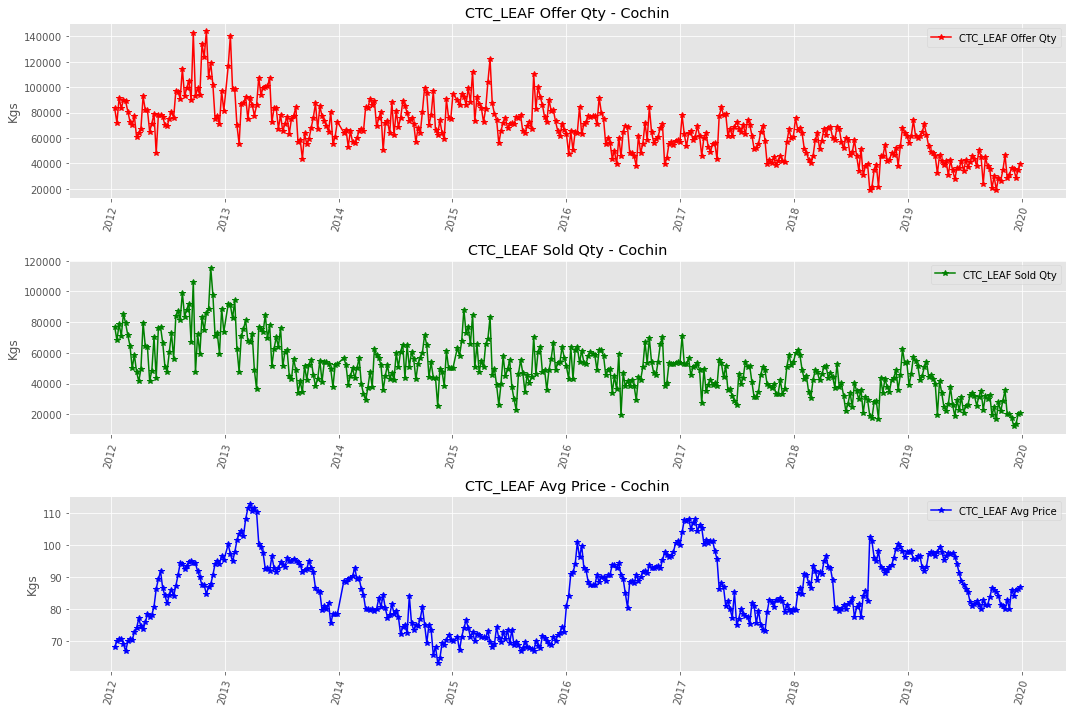

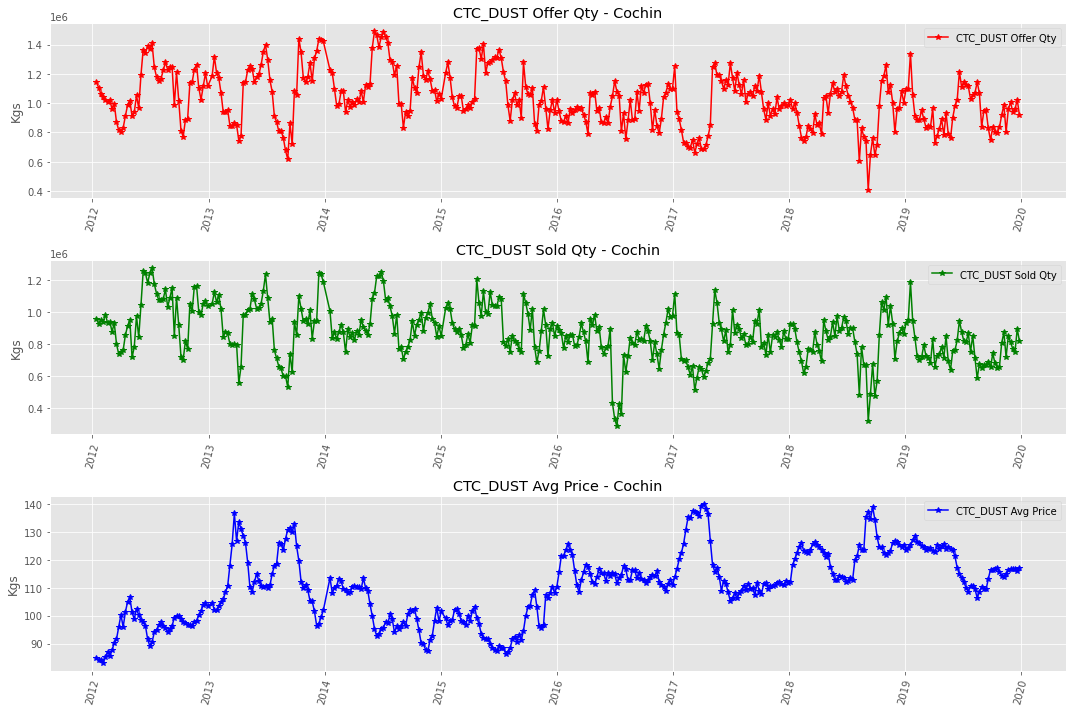

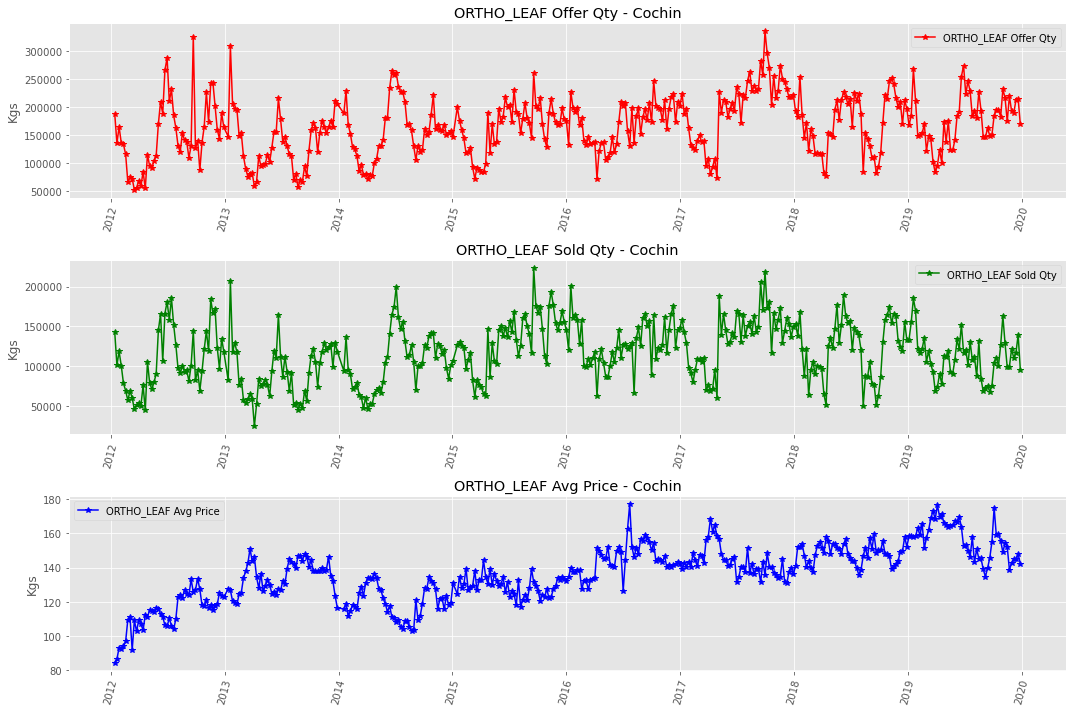

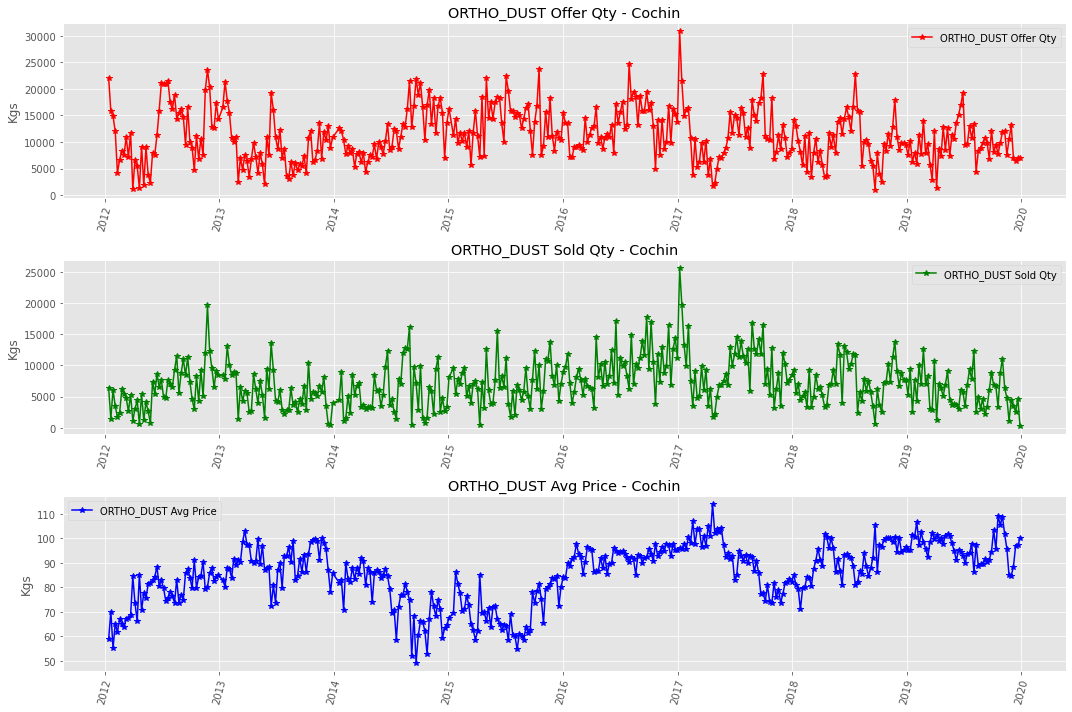

In [323]:
plot_oqty_sqty_avgp(df_CHN_CTC_leaf, 'ctc_leaf', 'Cochin')
plot_oqty_sqty_avgp(df_CHN_CTC_dust, 'ctc_dust', 'Cochin')
plot_oqty_sqty_avgp(df_CHN_Ortho_leaf, 'ortho_leaf', 'Cochin')
plot_oqty_sqty_avgp(df_CHN_Ortho_dust, 'ortho_dust', 'Cochin')

The plan:

First run only price data to do a univariate LSTM
Check results for all data including 2020
Check results for 2019 data only, compare predictions with known 2020 data

Then do multivariate with price, offer qty and sold qty, for 1 tea category
Then add all categories

## Code from the lecture

First we need to get the data into a format we can put into an RNN. Each training data point should consist of a sequence of consecutive values for our data (for input) and the next value of our data (for output).

First we'll write a function to consider every possible group of 52 values followed by one value (for the output) along our time-series data.

In [95]:
# Set up the first price series
price_series = df_CHN_CTC_leaf['ctc_leaf_avg_price']
time_series = price_series.index #pd.to_datetime(df_CHN_CTC_leaf['week_ending'])
# price_series.index = time_series
time_series

Index(['14-Jan-12', '21-Jan-12', '28-Jan-12', '4-Feb-12', '11-Feb-12',
       '18-Feb-12', '25-Feb-12', '3-Mar-12', '10-Mar-12', '17-Mar-12',
       ...
       '26-Oct-19', '2-Nov-19', '9-Nov-19', '16-Nov-19', '23-Nov-19',
       '30-Nov-19', '7-Dec-19', '14-Dec-19', '21-Dec-19', '28-Dec-19'],
      dtype='object', name='week_ending', length=412)

In [96]:
def windowize_data(data, n_prev):
    n_predictions = len(data) - n_prev
    y = data[n_prev:]
    # this might be too clever
    indices = np.arange(n_prev) + np.arange(n_predictions)[:, None]
    x = data[indices, None]
    return x, y

Then we'll write a function split the data into training and testing sets. Because it's time-series data we have to do that sequentially rather than shuffling it. They should be completely separate and not overlap, so the the training data isn't used for testing.

In [165]:
def split_and_windowize(data, n_prev, fraction_test=0.05):
    n_predictions = len(data) - 2*n_prev
    
    n_test  = int(fraction_test * n_predictions)
    n_train = n_predictions - n_test   
    
    x_train, y_train = windowize_data(data[:n_train], n_prev)
    x_test, y_test = windowize_data(data[n_train:], n_prev)
    return x_train, x_test, y_train, y_test

In [166]:
df_CHN_CTC_leaf

,year,serial_no,ctc_leaf_offer_qty,ctc_leaf_sold_qty,ctc_leaf_avg_price
week_ending,,,,,
14-Jan-12,2012,2,83325.0,77015.0,68.03
21-Jan-12,2012,3,71897.0,68187.0,70.11
28-Jan-12,2012,4,91279.0,78695.0,70.73
4-Feb-12,2012,5,83746.0,71188.0,70.63
11-Feb-12,2012,6,89650.0,85480.0,69.23
...,...,...,...,...,...
30-Nov-19,2019,48,36457.0,17801.0,86.08
7-Dec-19,2019,49,35657.0,12185.0,84.15
14-Dec-19,2019,50,28768.0,13576.0,85.86


In [247]:
n_prev = 13

x_train, x_test, y_train, y_test = split_and_windowize(price_series.values, n_prev)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

# ((363, 10, 3), (29, 10, 3), (363, 3), (29, 3))

((354, 13, 1), (32, 13, 1), (354,), (32,))

One of the difficulties with traditional RNNs is what's called the "vanishing gradients problem." For neural networks (this is 50 levels deep!) the effect of the input at the beginning exponentially shrinks with the depth of the network. This makes it very hard to remember details from the disThe the signal from each successively earlier point is typically smaller (or maybe larger) than the previous is that while they can "remember" what happened recently, 

There are other architectures of RNNs that will do a better job. One is a Long Short Term Memory (LSTM) network; a good post detailing them is at [http://colah.github.io/posts/2015-08-Understanding-LSTMs/]

In [248]:
# LSTM_price_model = keras.Sequential()

# LSTM_price_model.add(keras.layers.LSTM(52, input_shape=(n_prev, 1), return_sequences=True))

# LSTM_price_model.add(keras.layers.LSTM(52, return_sequences=False))

# LSTM_price_model.add(keras.layers.Dense(1, activation='relu')) # 'linear'

# LSTM_price_model.compile(optimizer='adam', loss='mse')

In [249]:
LSTM_price_model = keras.Sequential()

LSTM_price_model.add(keras.layers.LSTM(52, input_shape=(n_prev, 1), return_sequences=True))

LSTM_price_model.add(keras.layers.LSTM(52, return_sequences=False))

LSTM_price_model.add(keras.layers.Dense(1, activation='relu')) # 'linear'

LSTM_price_model.compile(optimizer='adam', loss='mse')

In [250]:
LSTM_price_model.summary()

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_72 (LSTM)               (None, 13, 52)            11232     
_________________________________________________________________
lstm_73 (LSTM)               (None, 52)                21840     
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 53        
Total params: 33,125
Trainable params: 33,125
Non-trainable params: 0
_________________________________________________________________


In [251]:
x_train.mean()

85.48864189482833

In [257]:
LSTM_price_model.fit(x_train, y_train, batch_size=10, epochs=100)

Epoch 1/100
354/354 [==============================] - 1s 3ms/sample - loss: 10.8264
Epoch 2/100
354/354 [==============================] - 1s 3ms/sample - loss: 10.4942
Epoch 3/100
354/354 [==============================] - 1s 3ms/sample - loss: 10.0115
Epoch 4/100
354/354 [==============================] - 1s 3ms/sample - loss: 9.8870
Epoch 5/100
354/354 [==============================] - 1s 3ms/sample - loss: 10.9519
Epoch 6/100
354/354 [==============================] - 1s 3ms/sample - loss: 10.2641
Epoch 7/100
354/354 [==============================] - 1s 3ms/sample - loss: 10.8273
Epoch 8/100
354/354 [==============================] - 1s 3ms/sample - loss: 10.0658
Epoch 9/100
354/354 [==============================] - 1s 3ms/sample - loss: 10.1085
Epoch 10/100
354/354 [==============================] - 1s 3ms/sample - loss: 11.5787
Epoch 11/100
354/354 [==============================] - 1s 3ms/sample - loss: 10.2176
Epoch 12/100
354/354 [==============================] - 1s 4ms/s

354/354 [==============================] - 2s 4ms/sample - loss: 10.4458
Epoch 97/100
354/354 [==============================] - 1s 4ms/sample - loss: 9.7592
Epoch 98/100
354/354 [==============================] - 1s 4ms/sample - loss: 10.0993
Epoch 99/100
354/354 [==============================] - 1s 4ms/sample - loss: 10.0851
Epoch 100/100
354/354 [==============================] - 1s 4ms/sample - loss: 9.8632


In [318]:
def get_timestamp():
    timestamp =   str(datetime.now().year) + '_'\
                + str(datetime.now().month).zfill(2) + '_'\
                + str(datetime.now().day).zfill(2) + '_'\
                + str(datetime.now().hour).zfill(2) + '_'\
                + str(datetime.now().minute).zfill(2) + '_'\
                + str(datetime.now().second).zfill(2)
    return timestamp

In [303]:
# ## Pickle the model
# # Save the Modle to file in the current working directory
# timestamp =   str(datetime.now().year) + '_'\
#             + str(datetime.now().month).zfill(2) + '_'\
#             + str(datetime.now().day).zfill(2) + '_'\
#             + str(datetime.now().hour).zfill(2) + '_'\
#             + str(datetime.now().minute).zfill(2) + '_'\
#             + str(datetime.now().second).zfill(2)


# pickled_model_filename = '../Models/LSTM_price_model_' + LSTM_price_model.name + '_' + timestamp + '.pkl'  

# with open(pickled_model_filename, 'wb') as file:  
#     pickle.dump(LSTM_price_model, file)

# # Load the Model back from file
# with open(pickled_model_filename, 'rb') as file:  
#     pickled_LSTM_price_model = pickle.load(file)

# pickled_LSTM_price_model

TypeError: can't pickle _thread.RLock objects

## Predictions from LSTM Univariate

In [265]:
y_pred = LSTM_price_model.predict(x_test)
y_pred

array([[97.40682 ],
       [97.59445 ],
       [96.211395],
       [93.63337 ],
       [90.25006 ],
       [87.549614],
       [86.280754],
       [85.66256 ],
       [85.0446  ],
       [82.542305],
       [81.145905],
       [81.25875 ],
       [82.17507 ],
       [81.68649 ],
       [80.76462 ],
       [82.58375 ],
       [81.5452  ],
       [81.78979 ],
       [83.49333 ],
       [86.711525],
       [86.86135 ],
       [86.324326],
       [84.325615],
       [81.390495],
       [80.52391 ],
       [80.02788 ],
       [82.387436],
       [80.880585],
       [86.31421 ],
       [84.5053  ],
       [86.94837 ],
       [86.429214]], dtype=float32)

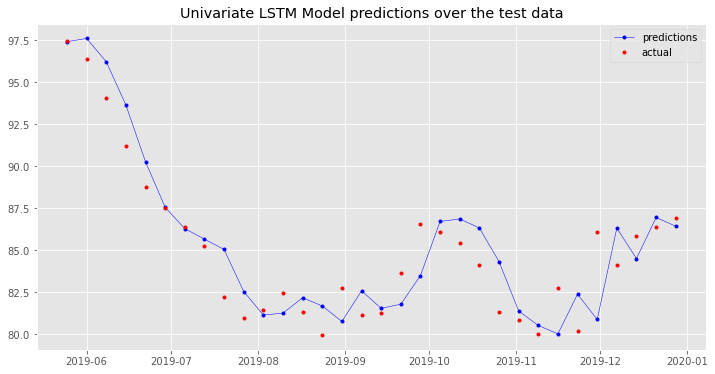

In [319]:
# Plot the predictions (one step ahead) against the test data
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(pd.to_datetime(time_series[-len(y_pred):]), y_pred, 'b.-', label='predictions', lw=0.5)
ax.plot(pd.to_datetime(time_series[-len(y_pred):]), y_test, 'r.', label='actual')
ax.set_title('Univariate LSTM Model predictions over the test data')
fig.savefig('../Images/UnivariateLSTMModelPredictions_testdata_' + get_timestamp())
ax.legend();

In [306]:
# Calculating MAPE (Mean Absolute Precentage Error)
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [307]:
# Calaculate MAPE
print(f'MAPE for know data (before 2020) = {mape(price_series, y_pred)}')

MAPE for know data (before 2020) = 11.470339365080674


In [259]:
# multi-step encoder-decoder lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

In [261]:
# define dataset
X = array([[10, 20, 30], [20, 30, 40], [30, 40, 50], [40, 50, 60]])
y = array([[40,50],[50,60],[60,70],[70,80]])

In [263]:
X, y

(array([[10, 20, 30],
        [20, 30, 40],
        [30, 40, 50],
        [40, 50, 60]]),
 array([[40, 50],
        [50, 60],
        [60, 70],
        [70, 80]]))

In [ ]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))
y = y.reshape((y.shape[0], y.shape[1], 1))

In [264]:
X, y

(array([[10, 20, 30],
        [20, 30, 40],
        [30, 40, 50],
        [40, 50, 60]]),
 array([[40, 50],
        [50, 60],
        [60, 70],
        [70, 80]]))

In [258]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(3, 1)))
model.add(RepeatVector(2))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=100, verbose=0)
# demonstrate prediction
x_input = array([50, 60, 70])
x_input = x_input.reshape((1, 3, 1))
yhat = model.predict(x_input, verbose=0)
print(yhat)

Using TensorFlow backend.



[[[77.34466]
  [89.78795]]]
